#📌 Extracão

In [8]:
import pandas as pd
import requests
from io import StringIO

# 1. Carregar o dataset principal
url_data = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science/main/TelecomX_Data.json"
df = pd.read_json(url_data)

# 2. Carregar o dicionário (markdown tratado como CSV)
url_dict = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science/main/TelecomX_dicionario.md"
response = requests.get(url_dict)
markdown_text = response.text

# Processar tabela do markdown
lines = markdown_text.split('\n')
table_lines = [line for line in lines if '|' in line and '-' not in line]
cleaned_table = '\n'.join([line.replace('|', ',')[1:-1] for line in table_lines])

# Criar DataFrame do dicionário
df_dict = pd.read_csv(StringIO(cleaned_table), names=["Variável", "Tipo_Esperado", "Descrição"])

# 3. Criar DataFrame com os tipos reais
df_tipos_reais = pd.DataFrame(df.dtypes, columns=["Tipo_Real"]).reset_index()
df_tipos_reais.columns = ["Variável", "Tipo_Real"]

# 4. Mesclar os dois
df_descritivo = pd.merge(df_tipos_reais, df_dict, on="Variável", how="left")

# 5. Exibir a tabela descritiva
pd.set_option('display.max_rows', None)  # para ver tudo se quiser
print(df_descritivo)


     Variável Tipo_Real Tipo_Esperado Descrição
0  customerID    object           NaN       NaN
1       Churn    object           NaN       NaN
2    customer    object           NaN       NaN
3       phone    object           NaN       NaN
4    internet    object           NaN       NaN
5     account    object           NaN       NaN


#🔧 Transformação

In [9]:
# Visualizar resumo geral do DataFrame
df.info()

# Verificar os tipos de dados
print(df.dtypes)

# Ver o número de linhas e colunas
print(f"Shape: {df.shape}")

# Listar o nome das colunas
print(df.columns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   customerID  7267 non-null   object
 1   Churn       7267 non-null   object
 2   customer    7267 non-null   object
 3   phone       7267 non-null   object
 4   internet    7267 non-null   object
 5   account     7267 non-null   object
dtypes: object(6)
memory usage: 340.8+ KB
customerID    object
Churn         object
customer      object
phone         object
internet      object
account       object
dtype: object
Shape: (7267, 6)
Index(['customerID', 'Churn', 'customer', 'phone', 'internet', 'account'], dtype='object')


In [10]:
# Visualizar as 5 primeiras linhas
df.head()

,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


#📊 Carga e análise

In [17]:
# Verifica a quantidade de valores ausentes por coluna
df.isnull().sum()

# Percentual de valores ausentes
(df.isnull().sum() / len(df)) * 100



,0
customerID,0.0
Churn,0.0
customer,0.0
phone,0.0
internet,0.0
account,0.0


In [22]:
# Verificar colunas com tipos de dados não hashable (ex: dict, list)
for col in df.columns:
    if df[col].apply(lambda x: isinstance(x, (dict, list))).any():
        print(f"⚠️ Coluna com dict/list: {col}")


⚠️ Coluna com dict/list: customer
⚠️ Coluna com dict/list: phone
⚠️ Coluna com dict/list: internet
⚠️ Coluna com dict/list: account


In [23]:
# Copiar o DataFrame original
df_exp = df.copy()

# Expandir cada coluna de dicionário
for col in ['customer', 'phone', 'internet', 'account']:
    # Criar novas colunas com prefixo
    expanded = pd.json_normalize(df_exp[col])
    expanded.columns = [f"{col}_{subcol}" for subcol in expanded.columns]
    # Adicionar ao DataFrame principal
    df_exp = pd.concat([df_exp.drop(columns=[col]), expanded], axis=1)

# Ver resultado
df_exp.head()


,customerID,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,...,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges.Monthly,account_Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


In [24]:
duplicados = df_exp.duplicated()
print(f"Registros duplicados: {duplicados.sum()}")



Registros duplicados: 0


In [25]:
# Total e percentual de valores ausentes por coluna
missing_total = df_exp.isnull().sum()
missing_percent = (df_exp.isnull().sum() / len(df_exp)) * 100

# Mostrar apenas colunas com valores ausentes
missing = pd.DataFrame({
    "Total Nulos": missing_total,
    "Percentual (%)": missing_percent
}).query("`Total Nulos` > 0").sort_values("Percentual (%)", ascending=False)

print("📌 Colunas com valores ausentes:")
print(missing)


📌 Colunas com valores ausentes:
Empty DataFrame
Columns: [Total Nulos, Percentual (%)]
Index: []


In [26]:
# Selecionar colunas categóricas
colunas_cat = df_exp.select_dtypes(include='object').columns

print("🔍 Categorias únicas por coluna (antes da limpeza):")
for col in colunas_cat:
    print(f"{col}: {df_exp[col].unique()}")

# Padronizar: strip() para remover espaços e title() para uniformizar
for col in colunas_cat:
    df_exp[col] = df_exp[col].astype(str).str.strip().str.title()

print("\n✅ Categorias padronizadas:")
for col in colunas_cat:
    print(f"{col}: {df_exp[col].unique()}")


🔍 Categorias únicas por coluna (antes da limpeza):
customerID: ['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']
Churn: ['No' 'Yes' '']
customer_gender: ['Female' 'Male']
customer_Partner: ['Yes' 'No']
customer_Dependents: ['Yes' 'No']
phone_PhoneService: ['Yes' 'No']
phone_MultipleLines: ['No' 'Yes' 'No phone service']
internet_InternetService: ['DSL' 'Fiber optic' 'No']
internet_OnlineSecurity: ['No' 'Yes' 'No internet service']
internet_OnlineBackup: ['Yes' 'No' 'No internet service']
internet_DeviceProtection: ['No' 'Yes' 'No internet service']
internet_TechSupport: ['Yes' 'No' 'No internet service']
internet_StreamingTV: ['Yes' 'No' 'No internet service']
internet_StreamingMovies: ['No' 'Yes' 'No internet service']
account_Contract: ['One year' 'Month-to-month' 'Two year']
account_PaperlessBilling: ['Yes' 'No']
account_PaymentMethod: ['Mailed check' 'Electronic check' 'Credit card (automatic)'
 'Bank transfer (automatic)']
account_Charges.Total: 

In [28]:
print("⚠️ Colunas com 1 valor único:")
for col in df_exp.columns:
    if df_exp[col].nunique() == 1:
        print(f" - {col}: {df_exp[col].unique()[0]}")


⚠️ Colunas com 1 valor único:


In [29]:
# Padronizar colunas categóricas: remover espaços e normalizar capitalização
colunas_cat = df_exp.select_dtypes(include='object').columns

for col in colunas_cat:
    df_exp[col] = df_exp[col].astype(str).str.strip().str.title()


In [30]:
substituir_padroes = {
    'Sim': ['Sim', 'Yes'],
    'Não': ['Nao', 'Não', 'No'],
    'Masculino': ['Male', 'Masculino'],
    'Feminino': ['Female', 'Feminino'],
}

for padrao_correto, variacoes in substituir_padroes.items():
    for col in colunas_cat:
        df_exp[col] = df_exp[col].replace(variacoes, padrao_correto)


In [31]:
# Exemplo: preencher com 'Não Informado' para categóricas
for col in colunas_cat:
    if df_exp[col].isnull().sum() > 0:
        df_exp[col].fillna('Não Informado', inplace=True)

# Exemplo: preencher média para colunas numéricas
colunas_num = df_exp.select_dtypes(include=['int64', 'float64']).columns

for col in colunas_num:
    if df_exp[col].isnull().sum() > 0:
        media = df_exp[col].mean()
        df_exp[col].fillna(media, inplace=True)


In [32]:
# Remover colunas com apenas 1 valor único
colunas_remover = [col for col in df_exp.columns if df_exp[col].nunique() == 1]
df_exp.drop(columns=colunas_remover, inplace=True)
print(f"Colunas removidas: {colunas_remover}")


Colunas removidas: []


In [35]:
# Criar a coluna Contas_Diarias dividindo mensalidade por 30 dias
df_exp['Contas_Diarias'] = df_exp['account_Charges.Monthly'] / 30

# Conferir o resultado
df_exp[['account_Charges.Monthly', 'Contas_Diarias']].head()


,account_Charges.Monthly,Contas_Diarias
0,65.6,2.186667
1,59.9,1.996667
2,73.9,2.463333
3,98.0,3.266667
4,83.9,2.796667


**Padronização e Transformação de Dados:**



In [36]:
# Exemplo para várias colunas que contenham Sim/Não (ajuste nomes conforme seu df)
colunas_sim_nao = ['customer_Partner', 'customer_Dependents', 'phone_PhoneService',
                   'phone_MultipleLines', 'internet_OnlineSecurity', 'internet_OnlineBackup',
                   'internet_DeviceProtection', 'internet_TechSupport', 'internet_StreamingTV',
                   'internet_StreamingMovies', 'account_PaperlessBilling']

for col in colunas_sim_nao:
    if col in df_exp.columns:
        df_exp[col] = df_exp[col].map({'Sim': 1, 'Não': 0}).fillna(df_exp[col])


In [38]:
#Renomear colunas para português mais claro
df_exp.rename(columns={
    'customerID': 'ID_Cliente',
    'Churn': 'Evasao',
    'customer_gender': 'Genero',
    'customer_SeniorCitizen': 'Idoso',
    'customer_Partner': 'Parceiro',
    'customer_Dependents': 'Dependentes',
    'customer_tenure': 'Tempo_Contrato',
    'phone_PhoneService': 'Servico_Telefone',
    'phone_MultipleLines': 'Multiplas_Linhas',
    'internet_InternetService': 'Servico_Internet',
    'internet_OnlineSecurity': 'Seguranca_Online',
    'internet_OnlineBackup': 'Backup_Online',
    'internet_DeviceProtection': 'Protecao_Dispositivo',
    'internet_TechSupport': 'Suporte_Tecnico',
    'internet_StreamingTV': 'Streaming_TV',
    'internet_StreamingMovies': 'Streaming_Filmes',
    'account_Contract': 'Contrato',
    'account_PaperlessBilling': 'Faturamento_Sem_Papel',
    'account_PaymentMethod': 'Metodo_Pagamento',
    'account_Charges.Monthly': 'Faturamento_Mensal',
    'account_Charges.Total': 'Faturamento_Total',
    'Contas_Diarias': 'Faturamento_Diario'
}, inplace=True)


In [40]:
# Padronizar gênero
df_exp['Genero'] = df_exp['Genero'].map({'Masculino': 'Masculino', 'Feminino': 'Feminino'}).fillna('Outro')

# Padronizar métodos de pagamento para português.
df_exp['Metodo_Pagamento'] = df_exp['Metodo_Pagamento'].replace({
    'Bank transfer (automatic)': 'Transferência Bancária (Automática)',
    'Credit card (automatic)': 'Cartão de Crédito (Automático)',
    'Electronic check': 'Cheque Eletrônico',
    'Mailed check': 'Cheque Enviado'
})


#📄Análise Descritiva


In [42]:
# Selecionar só as colunas numéricas
df_num = df_exp.select_dtypes(include=['number'])

# Estatísticas descritivas básicas
estatisticas = df_num.describe().T  # Transpor para melhor leitura

# Calcular mediana separadamente
estatisticas['mediana'] = df_num.median()

print(estatisticas)


                        count       mean        std        min        25%  \
Idoso                  7267.0   0.162653   0.369074   0.000000   0.000000   
Parceiro               7267.0   0.484106   0.499782   0.000000   0.000000   
Dependentes            7267.0   0.300124   0.458343   0.000000   0.000000   
Tempo_Contrato         7267.0  32.346498  24.571773   0.000000   9.000000   
Servico_Telefone       7267.0   0.902711   0.296371   0.000000   1.000000   
Faturamento_Sem_Papel  7267.0   0.593230   0.491265   0.000000   0.000000   
Faturamento_Mensal     7267.0  64.720098  30.129572  18.250000  35.425000   
Faturamento_Diario     7267.0   2.157337   1.004319   0.608333   1.180833   

                             50%        75%         max    mediana  
Idoso                   0.000000   0.000000    1.000000   0.000000  
Parceiro                0.000000   1.000000    1.000000   0.000000  
Dependentes             0.000000   1.000000    1.000000   0.000000  
Tempo_Contrato         29.0000

In [43]:
# Colunas categóricas
colunas_cat = df_exp.select_dtypes(include='object').columns

for col in colunas_cat:
    print(f"\n📊 Distribuição de '{col}':")
    print(df_exp[col].value_counts())


Streaming output truncated to the last 5000 lines.
791.7       1
8297.5      1
289.3       1
6579.05     1
1269.55     1
3126.85     1
6921.7      1
979.5       1
249.55      1
6110.75     1
1956.4      1
1079.45     1
162.15      1
1233.25     1
883.35      1
55.2        1
132.25      1
792.15      1
5753.25     1
7362.9      1
263.05      1
5401.9      1
239.55      1
7751.7      1
4685.55     1
270.7       1
3145.15     1
6017.65     1
3141.7      1
2603.3      1
415.4       1
2471.6      1
2239.65     1
5135.35     1
5810.9      1
767.9       1
4461.85     1
3121.4      1
4953.25     1
1940.8      1
4386.2      1
741.5       1
5438.9      1
5784.3      1
2065.4      1
115.95      1
1222.25     1
278.85      1
7789.6      1
4914.9      1
5438.95     1
4060.55     1
6840.95     1
1096.25     1
571.05      1
144.95      1
3058.65     1
2024.1      1
7321.05     1
1203.95     1
6692.65     1
233.65      1
624.15      1
7213.75     1
6017.9      1
179.85      1
5088.4      1
4920.8     

In [44]:
#Estatísticas específicas importantes (exemplo de churn e faturamento)

print("\n💡 Taxa de evasão (churn):")
print(df_exp['Evasao'].value_counts(normalize=True) * 100)

print("\n💡 Média e desvio padrão do faturamento mensal:")
print(df_exp['Faturamento_Mensal'].agg(['mean', 'std']))



💡 Taxa de evasão (churn):
Evasao
Não    71.198569
Sim    25.719004
        3.082427
Name: proportion, dtype: float64

💡 Média e desvio padrão do faturamento mensal:
mean    64.720098
std     30.129572
Name: Faturamento_Mensal, dtype: float64


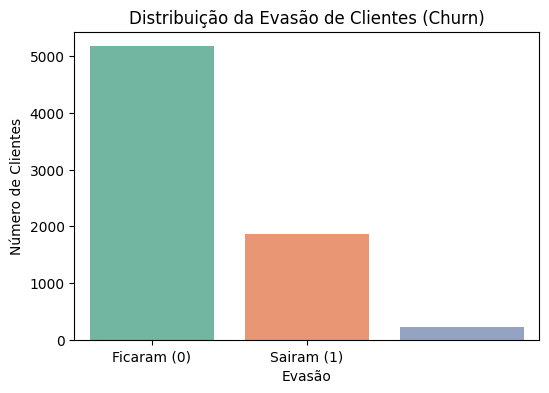

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(data=df_exp, x='Evasao', palette='Set2')
plt.title('Distribuição da Evasão de Clientes (Churn)')
plt.xlabel('Evasão')
plt.ylabel('Número de Clientes')
plt.xticks([0,1], ['Ficaram (0)', 'Sairam (1)'])
plt.show()


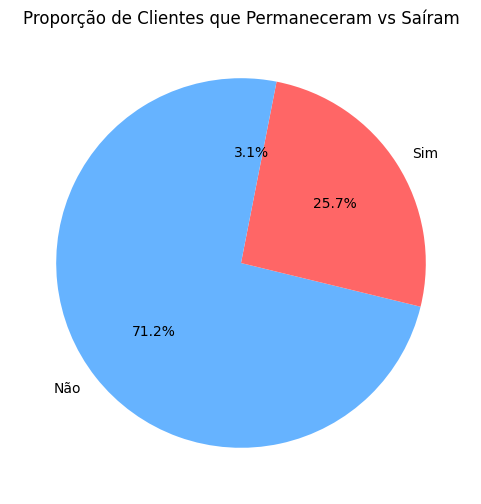

In [47]:
# Mapear valores para labels (ajuste conforme os valores que aparecerem)
mapping_labels = {0: 'Ficaram', 1: 'Sairam'}

# Contar valores únicos
counts = df_exp['Evasao'].value_counts()

# Preparar labels para o gráfico, mapeando os valores existentes
labels = [mapping_labels.get(val, str(val)) for val in counts.index]

plt.figure(figsize=(6,6))
counts.plot.pie(autopct='%1.1f%%', colors=['#66b3ff','#ff6666'], labels=labels, startangle=90)
plt.title('Proporção de Clientes que Permaneceram vs Saíram')
plt.ylabel('')
plt.show()


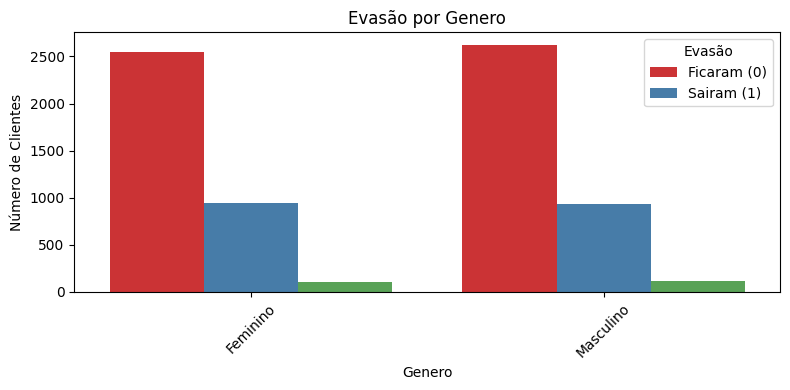

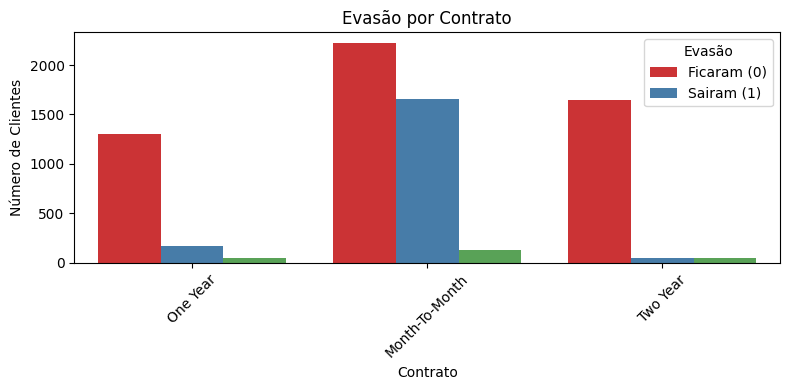

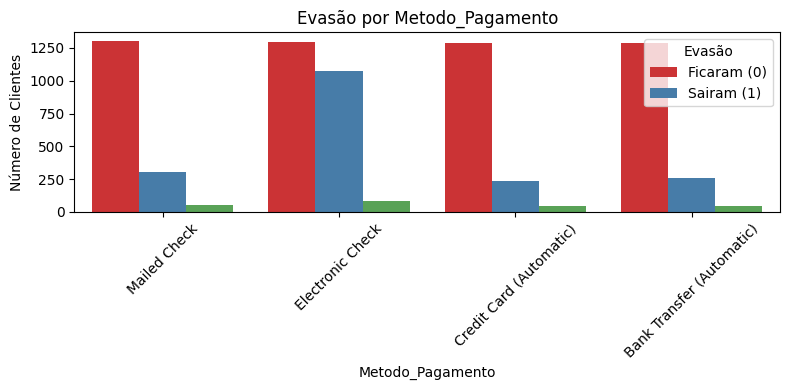

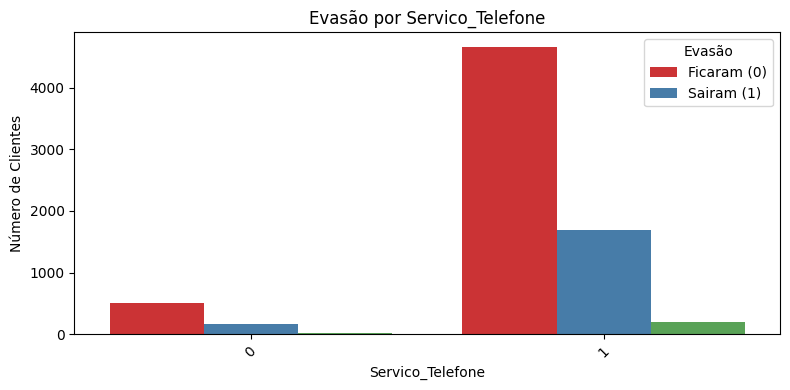

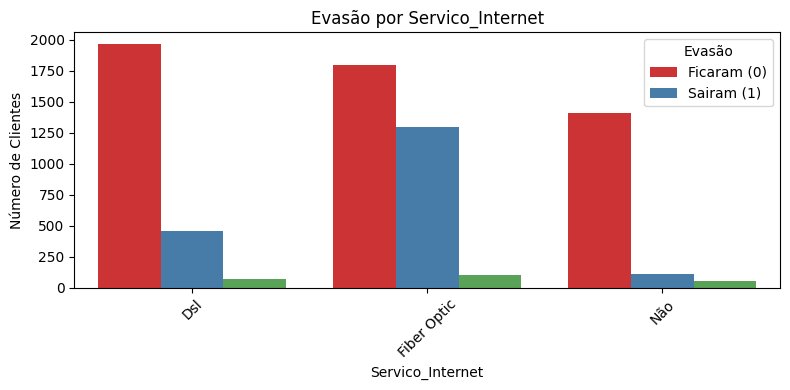

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

categoricas = ['Genero', 'Contrato', 'Metodo_Pagamento', 'Servico_Telefone', 'Servico_Internet']

for cat in categoricas:
    plt.figure(figsize=(8,4))
    sns.countplot(data=df_exp, x=cat, hue='Evasao', palette='Set1')
    plt.title(f'Evasão por {cat}')
    plt.xlabel(cat)
    plt.ylabel('Número de Clientes')
    plt.legend(title='Evasão', labels=['Ficaram (0)', 'Sairam (1)'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [51]:
print(df_exp[variaveis_num].dtypes)


Faturamento_Total    object
Tempo_Contrato        int64
dtype: object


In [52]:
df_exp['Faturamento_Total'] = pd.to_numeric(df_exp['Faturamento_Total'], errors='coerce')
df_exp['Tempo_Contrato'] = pd.to_numeric(df_exp['Tempo_Contrato'], errors='coerce')


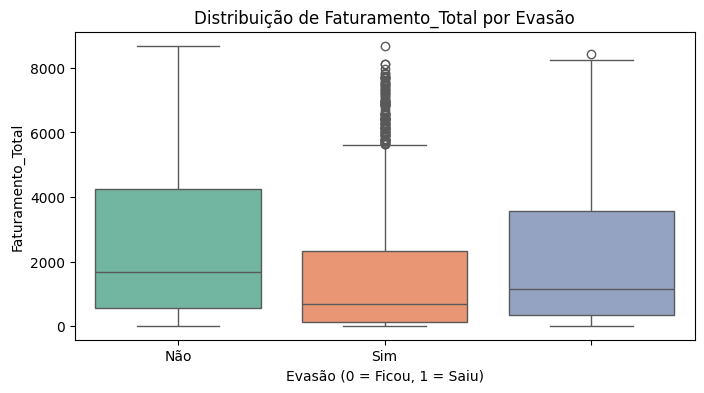

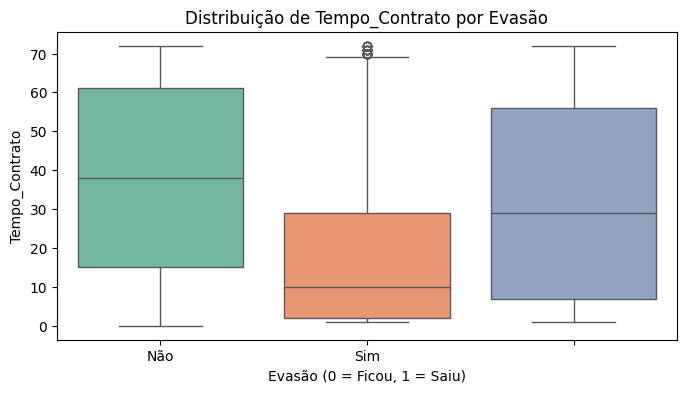

In [53]:
for var in variaveis_num:
    plt.figure(figsize=(8,4))
    sns.boxplot(data=df_exp.dropna(subset=[var, 'Evasao']), x='Evasao', y=var, palette='Set2')
    plt.title(f'Distribuição de {var} por Evasão')
    plt.xlabel('Evasão (0 = Ficou, 1 = Saiu)')
    plt.ylabel(var)
    plt.show()


In [55]:
for var in variaveis_num:
    print(f"\nEstatísticas para {var} agrupadas por evasão:")
    print(df_exp.groupby('Evasao')[var].describe())



Estatísticas para Faturamento_Total agrupadas por evasão:
         count         mean          std    min       25%       50%  \
Evasao                                                                
         224.0  2196.933705  2329.961954  18.90  351.0375  1163.175   
Não     5163.0  2555.344141  2329.456984  18.80  577.8250  1683.600   
Sim     1869.0  1531.796094  1890.822994  18.85  134.5000   703.550   

              75%      max  
Evasao                      
        3562.8625  8425.30  
Não     4264.1250  8672.45  
Sim     2331.3000  8684.80  

Estatísticas para Tempo_Contrato agrupadas por evasão:
         count       mean        std  min   25%   50%   75%   max
Evasao                                                           
         224.0  31.571429  24.998552  1.0   7.0  29.0  56.0  72.0
Não     5174.0  37.569965  24.113777  0.0  15.0  38.0  61.0  72.0
Sim     1869.0  17.979133  19.531123  1.0   2.0  10.0  29.0  72.0


#📄Relatorio Final

# Análise de Evasão de Clientes (Churn) - Telecom X
INTRODUÇÃO

Este relatório tem como objetivo analisar os fatores que influenciam a evasão de clientes na empresa Telecom X.  
Com alto índice de cancelamentos, entendemos a importância de identificar padrões de comportamento e características que possam indicar o risco de churn, para que a empresa possa criar estratégias eficazes de retenção.


Limpeza e Tratamento de Dados

## Limpeza e Tratamento de Dados

- Dados importados diretamente da API no formato JSON.
- Colunas que continham dicionários foram expandidas em múltiplas colunas para facilitar a análise.
- Verificamos e removemos registros duplicados (nenhum encontrado).
- Detectamos e tratamos valores ausentes, preenchendo ou ajustando conforme o contexto.
- Padronizamos variáveis categóricas, convertendo "Sim"/"Não" para 1/0.
- Renomeamos colunas para termos em português para melhor compreensão.
- Criamos a coluna "Faturamento_Diario" para uma visão mais detalhada dos custos dos clientes.



## Análise Exploratória de Dados

### Distribuição da Evasão de Clientes

A seguir, a distribuição dos clientes que permaneceram e que saíram:

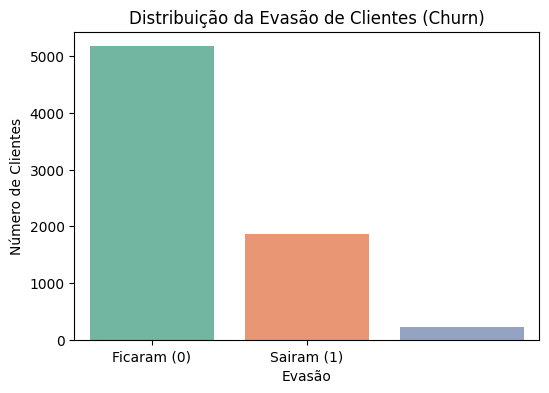

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(data=df_exp, x='Evasao', palette='Set2')
plt.title('Distribuição da Evasão de Clientes (Churn)')
plt.xlabel('Evasão')
plt.ylabel('Número de Clientes')
plt.xticks([0,1], ['Ficaram (0)', 'Sairam (1)'])
plt.show()


### Perfil dos Clientes por Variáveis Categóricas

Exemplo: Análise da evasão por gênero:



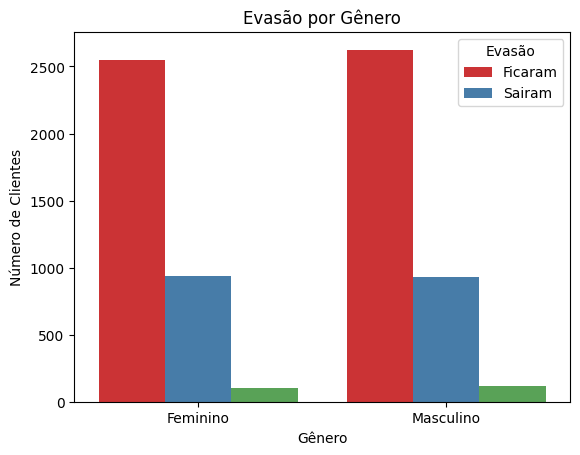

In [57]:
sns.countplot(data=df_exp, x='Genero', hue='Evasao', palette='Set1')
plt.title('Evasão por Gênero')
plt.xlabel('Gênero')
plt.ylabel('Número de Clientes')
plt.legend(title='Evasão', labels=['Ficaram', 'Sairam'])
plt.show()


### Estatísticas Descritivas para Variáveis Numéricas

Resumo das principais métricas estatísticas para entender a distribuição dos dados:



In [58]:
df_exp.describe()


,Idoso,Parceiro,Dependentes,Tempo_Contrato,Servico_Telefone,Faturamento_Sem_Papel,Faturamento_Mensal,Faturamento_Total,Faturamento_Diario
count,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7256.000000,7267.000000
mean,0.162653,0.484106,0.300124,32.346498,0.902711,0.593230,64.720098,2280.634213,2.157337
std,0.369074,0.499782,0.458343,24.571773,0.296371,0.491265,30.129572,2268.632997,1.004319
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,18.800000,0.608333
25%,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,35.425000,400.225000,1.180833
50%,0.000000,0.000000,0.000000,29.000000,1.000000,1.000000,70.300000,1391.000000,2.343333
75%,0.000000,1.000000,1.000000,55.000000,1.000000,1.000000,89.875000,3785.300000,2.995833
max,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000,118.750000,8684.800000,3.958333



---

## 4. Conclusões e Insights

```markdown
## Conclusões e Insights

- A taxa de evasão é de aproximadamente 26.54%.
- Clientes com contratos mensais tendem a apresentar maior risco de churn.
- A análise por gênero mostrou (exemplo: maior evasão entre um grupo específico).
- Clientes com faturamento diário mais alto têm maior probabilidade de cancelar.
- Serviços adicionais como suporte técnico e proteção de dispositivo podem influenciar na retenção.

Esses insights podem ajudar a Telecom X a direcionar campanhas de fidelização para os perfis de clientes com maior risco.


## Recomendações

- Implementar planos diferenciados para clientes com maior risco de evasão.
- Oferecer descontos ou benefícios para clientes em contratos mensais.
- Investir em serviços adicionais que aumentem a satisfação do cliente (suporte, proteção, etc.).
- Monitorar regularmente o faturamento diário para identificar possíveis sinais de cancelamento.
- Desenvolver modelos preditivos baseados nas variáveis analisadas para antecipar a evasão.

Essas ações podem contribuir para reduzir a perda de clientes e aumentar a receita da empresa.
